# Data preparation for model training for the MDDS

The objective of this notebook is to arrange data in order to train the model for time processing prediction.



In [ ]:
import os
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [ ]:
list_files = os.listdir('../data/BasedOnModelData/PreProcessData')
os.listdir('../data/BasedOnModelData/PreProcessData')

In [ ]:
from scipy.io import loadmat

In [ ]:
fc_mat_data = loadmat('../data/BasedOnModelData/PreProcessData/data_splicesFc_160.mat')
acc_mat_data = loadmat('../data/BasedOnModelData/PreProcessData/data_splicesAcc_160.mat')
spn_mat_data = loadmat('../data/BasedOnModelData/PreProcessData/data_splicesName_160.mat')


fc_mat_data = fc_mat_data['splicesFc'][0]
acc_mat_data = acc_mat_data['splicesAcc'][0]
spn_mat_data = spn_mat_data['splicesName'][0]

In [ ]:
spn_mat_data[4][0]

In [ ]:
print(np.max([mat.shape[1] for mat in fc_mat_data]))
print(np.argmax([mat.shape[1] for mat in fc_mat_data]))

In [ ]:
print(np.max([mat.shape[1] for mat in acc_mat_data]))
print(np.argmax([mat.shape[1] for mat in acc_mat_data]))

In [ ]:
longest_fc_mat = fc_mat_data[14]
longest_acc_mat = acc_mat_data[14]

df_append_fc = []  
df_append_acc = []  

for idx_mat, mat in tqdm(enumerate(fc_mat_data)):
    len_diff = 574 - mat.shape[1]
    
    if len_diff != 0:
        fill_array = np.empty((1000, len_diff))
        fill_array[:] = np.nan
        data_mat = np.hstack((mat, fill_array))
    else:
        data_mat=mat

    col_idx = test = ['TS_' + str(ts_idx) for ts_idx in range(574)]
    
    df_fc_mat = pd.DataFrame(data=data_mat, columns=col_idx)
    df_fc_mat['span_name'] = spn_mat_data[idx_mat][0]
    
    df_append_fc.append(df_fc_mat) 
    
    
    mat=acc_mat_data[idx_mat]
    
    if len_diff != 0:
        fill_array = np.empty((1000, len_diff))
        fill_array[:] = np.nan
        data_mat = np.hstack((mat, fill_array))
    else:
        data_mat=mat

    col_idx = test = ['TS_' + str(ts_idx) for ts_idx in range(574)]
    
    df_acc_mat = pd.DataFrame(data=data_mat, columns=col_idx)
    df_acc_mat['span_name'] = spn_mat_data[idx_mat][0]
    
    df_append_acc.append(df_acc_mat) 


In [ ]:
spn_mat_data[idx_mat][0]

In [ ]:
df_concatenate_fc = pd.concat(df_append_fc)

In [ ]:
df_append_fc[0]

In [ ]:
df_concatenate_fc = df_concatenate_fc.reset_index(drop=True)

In [ ]:
df_concatenate_fc.head()

In [ ]:
df_concatenate_acc = pd.concat(df_append_acc)
df_concatenate_acc = df_concatenate_acc.reset_index(drop=True)
df_concatenate_acc.head()

In [ ]:
df_concatenate_acc.iloc[0,:-1].plot()

In [ ]:
df_concatenate_fc['speed'] = 80/3.6
df_concatenate_acc['speed'] = 80/3.6

In [ ]:
df_concatenate_fc.head()

In [ ]:
def apply_classes(span):
    
    if span == spn_mat_data[4][0]:
        return 'MiddleDropper'
    elif span == spn_mat_data[9][0]:
        return 'FirstDropper'
    elif span == spn_mat_data[6][0]:
        return 'MiddleJunctionClamp'
    elif span == spn_mat_data[2][0]:
        return 'EndJunctionClamp'
    elif span == spn_mat_data[7][0] or span == spn_mat_data[11][0]:
        return 'endConsol'
    elif span == spn_mat_data[8][0] or span == spn_mat_data[10][0]:
        return 'startCOnsol'
    else:
        return 'Baseline'

    
df_concatenate_fc['classes'] = df_concatenate_fc['span_name'].apply(lambda x: apply_classes(x))
df_concatenate_acc['classes'] = df_concatenate_acc['span_name'].apply(lambda x: apply_classes(x))

In [ ]:
df_concatenate_fc['classes'].value_counts()

In [ ]:
df_concatenate_acc['classes'].value_counts()

In [ ]:
df_concatenate_fc.to_csv('../data/interim/fc_160.csv')
df_concatenate_acc.to_csv('../data/interim/acc_160.csv')

# Field Data preprocess

In [7]:
import os
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.io import loadmat
from scipy.signal import detrend
import seaborn as sns

In [2]:
folder_path = '../data/BasedOnFieldData/PreProcessedData/CEF2_23032016_PreProcessed_PK3PK6_Spliced_GPS_Poles'

list_files = os.listdir(folder_path)
print(list_files)

['Y_steady_arm_baseline.mat', 'x23032016_run12_descente_160kmh.mat', 'x23032016_run5_montee_100kmh.mat', 'Y_splicer_baseline.mat', 'extractFeaturesInsights.m', 'Untitled.m', 'x23032016_run3_montee_80kmh.mat', 'x23032016_run7_montee_120kmh.mat', 'x23032016_run13_montee_120kmh.mat', 'x23032016_run9_montee_135kmh.mat', 'x23032016_run10_descente_140kmh.mat', 'x23032016_run4_descente_80kmh.mat', 'x23032016_run11_montee_135kmh.mat', 'Y_dropper_baseline.mat', 'x23032016_run14_descente_120kmh.mat', 'x23032016_run8_descente_120kmh.mat', 'x23032016_run6_descente_100kmh.mat']


In [3]:
list_files = [file_name for file_name in list_files if 'kmh' in file_name]

In [ ]:
fc_mat_data = loadmat(folder_path + '/x23032016_run12_descente_160kmh.mat')

In [ ]:
span_names = fc_mat_data['MyStruct'][0][0][-1][0]
span_names

In [ ]:
for span in span_names:
    print(span[0])

In [ ]:
span_data = fc_mat_data['MyStruct'][0][0][-2][0]
span_data

In [15]:
df_append = []

for file_name in tqdm(list_files):
    
    relative_path = folder_path + '/' + file_name
    mat_file_content = loadmat(relative_path)
    
    direction = file_name.split('_')[2]
    span_names = mat_file_content['MyStruct'][0][0][-1][0]
    span_data = mat_file_content['MyStruct'][0][0][-2][0]
    
    cols = ['ts', 'AARD', 'AARG', 'AAVD', 'AAVG', 'AM', 'Fc', 'Speed']
    
    df_span_append = []
    
    for idx_span, span in enumerate(span_names):
        
        data_span = span_data[idx_span]
        
        ts = np.arange(0, data_span.shape[0], 1).reshape(-1,1)
        AARD = data_span[:, 0].reshape(-1,1)
        AARG = data_span[:, 1].reshape(-1,1)
        AAVD = data_span[:, 2].reshape(-1,1)
        AAVG = data_span[:, 3].reshape(-1,1)
        AM = np.mean([AARD, AARG, AAVD, AAVG], axis = 0)
        Fc = data_span[:, 13].reshape(-1,1) - np.mean(data_span[:, 13].reshape(-1,1))
        Speed = data_span[:, 17].reshape(-1,1)
        
        
        data_selected = np.hstack([ts, AARD, AARG, AAVD, AAVG, AM, Fc, Speed])
        
        df_span = pd.DataFrame(data = data_selected, columns = cols)
        df_span['direction'] = direction
        df_span['span'] = span[0]
        str_id = file_name.split('_')[1] + '_' + span[0]
        df_span['id'] = str_id
        
        df_span_append.append(df_span)
    
    df_file = pd.concat(df_span_append)
    df_file = df_file.reset_index(drop=True)
    
    df_append.append(df_file)
    

df_total = pd.concat(df_append)


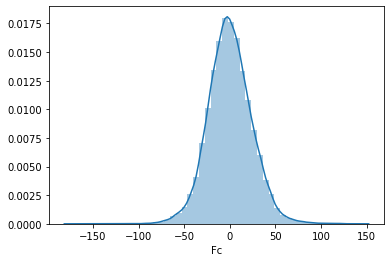

In [20]:
sns.distplot(df_total.Fc)

In [21]:
df_total.head()

,ts,AARD,AARG,AAVD,AAVG,AM,Fc,Speed,direction,span,id,classes
0,0.0,-6.569074,-10.717356,-9.113529,-7.193623,-8.398395,-54.558336,160.173004,descente,Span1,run12_Span1,splicer
1,1.0,-6.883555,-9.547513,-6.912798,-4.473680,-6.954387,-45.205767,160.173004,descente,Span1,run12_Span1,splicer
2,2.0,-6.022359,-6.864442,-8.345452,-4.435100,-6.416838,-32.390161,160.173004,descente,Span1,run12_Span1,splicer
3,3.0,-6.869041,-6.433753,-8.650504,-5.939749,-6.973262,-17.743624,160.173004,descente,Span1,run12_Span1,splicer
4,4.0,-4.662831,-5.525816,-9.712738,-9.759242,-7.415157,-3.026026,160.173004,descente,Span1,run12_Span1,splicer


In [22]:
def span_to_class(span):
    
    if span == 'Span3' or span == 'Span9':
        return 'Dropper'
    elif span == 'Span1' or span == 'Span5':
        return 'splicer'
    elif span == 'Span6' or span == 'Span7' or span == 'Span11' or span == 'Span12':
        return 'steadyArm'
    else:
        return 'Baseline'

df_total['classes'] =  df_total['span'].apply(lambda x: span_to_class(x))

In [23]:
df_total.head()

,ts,AARD,AARG,AAVD,AAVG,AM,Fc,Speed,direction,span,id,classes
0,0.0,-6.569074,-10.717356,-9.113529,-7.193623,-8.398395,-54.558336,160.173004,descente,Span1,run12_Span1,splicer
1,1.0,-6.883555,-9.547513,-6.912798,-4.473680,-6.954387,-45.205767,160.173004,descente,Span1,run12_Span1,splicer
2,2.0,-6.022359,-6.864442,-8.345452,-4.435100,-6.416838,-32.390161,160.173004,descente,Span1,run12_Span1,splicer
3,3.0,-6.869041,-6.433753,-8.650504,-5.939749,-6.973262,-17.743624,160.173004,descente,Span1,run12_Span1,splicer
4,4.0,-4.662831,-5.525816,-9.712738,-9.759242,-7.415157,-3.026026,160.173004,descente,Span1,run12_Span1,splicer


In [ ]:
df_total.to_csv('../data/interim/field_data.csv')